any data null  False


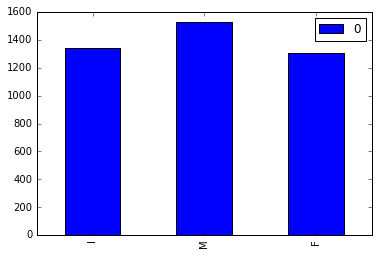

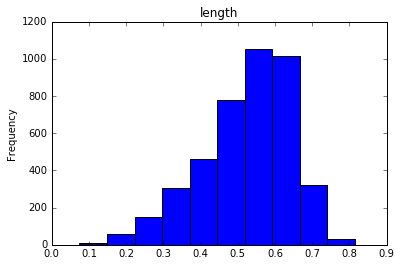

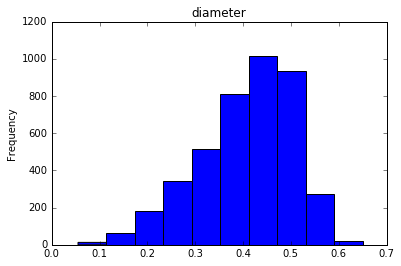

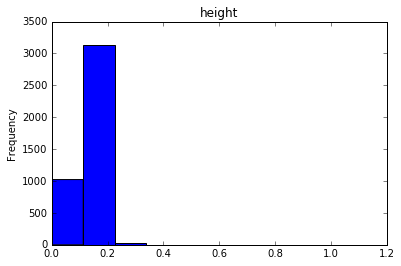

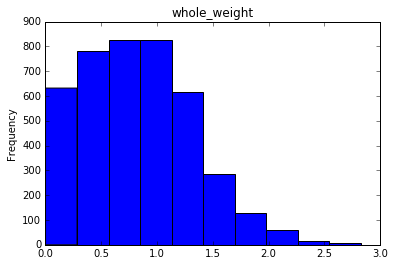

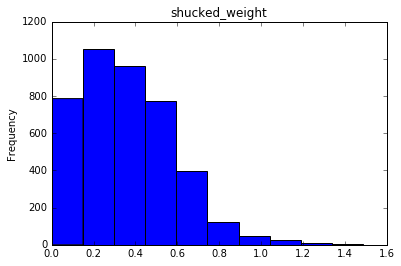

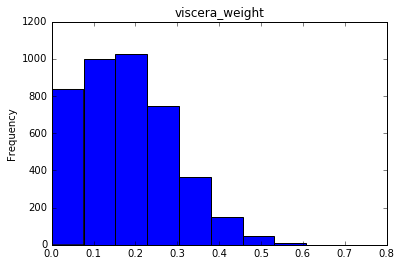

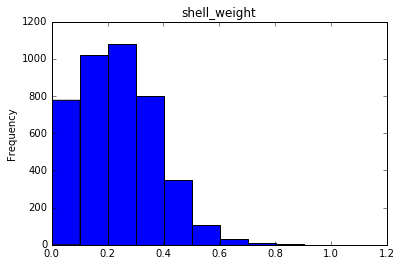

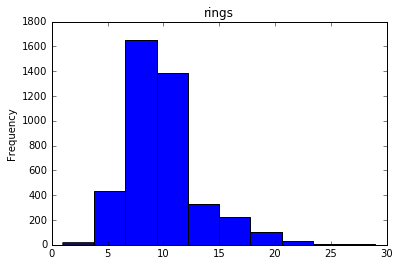

In [2]:
# Geoffrey So 9/30/2016

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# read data
'''
        Name            Data Type       Meas.   Description
        ----            ---------       -----   -----------
        Sex             nominal                 M, F, and I (infant)
        Length          continuous      mm      Longest shell measurement
        Diameter        continuous      mm      perpendicular to length
        Height          continuous      mm      with meat in shell
        Whole weight    continuous      grams   whole abalone
        Shucked weight  continuous      grams   weight of meat
        Viscera weight  continuous      grams   gut weight (after bleeding)
        Shell weight    continuous      grams   after being dried
        Rings           integer                 +1.5 gives the age in years
'''
names = ['sex','length','diameter','height','whole_weight','shucked_weight',
         'viscera_weight','shell_weight','rings']
df=pd.read_csv('abalone.data',header=None,names=names)

print('any data null ', df.isnull().values.any())

# plot histogram

# sex
counts = Counter(df['sex'].values)
plot_df = pd.DataFrame.from_dict(counts, orient='index')
plot_df.plot(kind='bar')

for column_name in names[1:]:
    plt.figure();
    df[column_name].plot.hist(title=column_name)

The distribution of count between male, female, infant are about the same, slightly more male than the other two.  The length of most of the abalone is around 0.6 * 200 mm so ~ 12cm, age around 10 rings+1.5 so in the old category.

In [1]:
# Geoffrey So 9/30/2016
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import logging
logging.getLogger().setLevel(logging.INFO)
import xgboost
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# read data
names = np.array(['sex','length','diameter','height','whole_weight',
                  'shucked_weight','viscera_weight','shell_weight','rings'])
df=pd.read_csv('abalone.data',header=None,names=names)

# change sex into one hot, remove from original, combine one hot with df
def convert_to_onehot(df):
    # assume data types are all consistent in each column
    value = df.values[0]
    is_number = np.array([])
    for item in value:
         is_number = np.append(is_number, isinstance(item, int)
                               or isinstance(item, float))
    # convert non-numeric to one hot
    non_number = names[is_number==0]
    to_onehot = df[non_number]
    one_hot = pd.get_dummies(to_onehot)
    # set temp dataframe to delete categorical columns from df
    temp = df.drop(df[non_number], axis=1, inplace=False)
    # combine one hot with temp 
    # assume no duplicate rows or have to use inner or outer etc
    return pd.concat([one_hot, temp], axis=1)

def convert_to_age_group(target):
    '''
    0: young
    1: medium
    2: old
    '''
    age_group = []
    offset = 1.5
    for ring_count in target:
        if ring_count < 9-offset:
            age_group.append(0)
        elif ring_count < 11-offset:
            age_group.append(1)
        else:
            age_group.append(2)
    return np.array(age_group).astype(np.int32)

data = convert_to_onehot(df)

# define answer
# will be changed later with 1.5 offset when the function convert_to_age_group is used
age = data['rings'].values

# remove rings (age) from df
data.drop('rings', axis=1, inplace=True)
data = data.values

# define index that separate train from test
data_length = len(data)
cross_valid_count = 10
test_size = int(len(data) / cross_valid_count)

# randomize the order of the data
np.random.seed(123456)
random_index = np.arange(data_length)
np.random.shuffle(random_index)
age = age[random_index]
data = data[random_index]

/home/geoffrey/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This will read in the data from the data file and we check that they are in the format we expect.
The 'data' should be a 2D matrix, columns of different features and rows of different sample.
The 'age' should be the ring count as a 1D array with the same length as 'data'

In [4]:
data

array([[ 1.    ,  0.    ,  0.    , ...,  0.4015,  0.217 ,  0.255 ],
       [ 0.    ,  0.    ,  1.    , ...,  0.2455,  0.1665,  0.185 ],
       [ 1.    ,  0.    ,  0.    , ...,  0.291 ,  0.1835,  0.235 ],
       ..., 
       [ 1.    ,  0.    ,  0.    , ...,  0.308 ,  0.169 ,  0.255 ],
       [ 0.    ,  1.    ,  0.    , ...,  0.169 ,  0.0825,  0.13  ],
       [ 1.    ,  0.    ,  0.    , ...,  0.4895,  0.1945,  0.2185]])

In [5]:
age

array([ 9, 10, 12, ...,  7,  7,  7])

In [6]:
# do cross validation by using different 10% of data as test set
all_accuracies = np.array([])
for i in range(10):
    train_set = np.concatenate((data[:i*test_size], data[(i+1)*test_size:]),
                               axis=0)
    train_target = np.concatenate((age[:i*test_size], age[(i+1)*test_size:]),
                                  axis=0)
    test_set = data[i * test_size:(i+1) * test_size]
    test_target = age[i * test_size:(i+1) * test_size]

    # convert data to young:0, medium:1, old:2 with 1.5 offset
    train_age_target = convert_to_age_group(train_target)
    test_age_target = convert_to_age_group(test_target)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=1000)
    rf.fit(train_set, train_age_target)
    # do prediction
    RF_predictions = rf.predict(test_set)
    RF_accuracy = accuracy_score(test_age_target, RF_predictions)

    # XGB
    model = xgboost.XGBClassifier(learning_rate=0.1,
                                  n_estimators=1000)
    model.fit(train_set, train_age_target)
    XGB_predictions = model.predict(test_set)
    #XGB_predictions = [round(value) for value in y_pred]
    # evaluate predictions
    XGB_accuracy = accuracy_score(test_age_target, XGB_predictions)

    # DNN
    # Specify that all features have real-value data
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=10)]
    # Build 3 layer DNN with 10, 20, 10 units respectively.
    
    classifier = tf.contrib.learn.DNNClassifier(
        feature_columns=feature_columns,
        hidden_units=[10,20],
        n_classes=3,
        optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.1)
        )
    classifier.fit(x=train_set,
                   y=train_age_target,
                   steps=1000)

    DNN_predictions = classifier.predict(test_set)
    DNN_accuracy = accuracy_score(test_age_target, DNN_predictions)
    
    current_accuracies = np.array([RF_accuracy,XGB_accuracy,DNN_accuracy])
    print('CURRENT ACCURACIES (RF,XGB,DDN)', current_accuracies)
    all_accuracies = np.concatenate([all_accuracies,current_accuracies])


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.06785, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.70503597  0.6882494   0.68345324]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.16442, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.70023981  0.71223022  0.70503597]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.06238, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.70503597  0.68585132  0.69304556]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.10043, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.71702638  0.72901679  0.73860911]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.07297, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.69784173  0.70503597  0.75059952]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.13908, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.67625899  0.6618705   0.69304556]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.23017, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.71223022  0.70983213  0.70743405]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.1832, step = 1
INFO:tensorflow:Saving checkpoint

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.74340528  0.73621103  0.73381295]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.03198, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.6882494   0.67146283  0.70263789]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.11497, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.75059952  0.73860911  0.74580336]


In [9]:
i

9

In [59]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
RF_precision = precision_score(test_age_target, RF_predictions)
XGB_precision = precision_score(test_age_target, XGB_predictions)
DNN_precision = precision_score(test_age_target, DNN_predictions)
print('precision', RF_precision, XGB_precision, DNN_precision)
RF_recall = recall_score(test_age_target, RF_predictions)
XGB_recall = recall_score(test_age_target, XGB_predictions)
DNN_recall = recall_score(test_age_target, DNN_predictions)
print('recall', RF_precision, XGB_precision, DNN_precision)

precision 0.724349461251 0.72775350074 0.717579127459
recall 0.724349461251 0.72775350074 0.717579127459


/home/geoffrey/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/geoffrey/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring

The performance of the precision:tp/(tp+fp) and recall:tp/(tp+fn) are all around 0.7 for all three ML models

Confusion matrix, without normalization
[[ 61  18   3]
 [ 13  58  34]
 [  3  33 194]]
Confusion matrix, without normalization
[[ 65  14   3]
 [ 11  56  38]
 [  3  40 187]]
Confusion matrix, without normalization
[[ 64  15   3]
 [ 11  60  34]
 [  4  39 187]]
average accuracy [ 0.70959233  0.70383693  0.71534772]


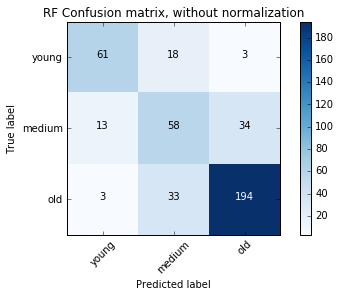

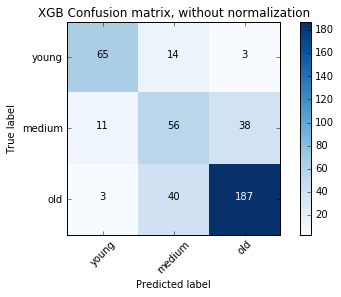

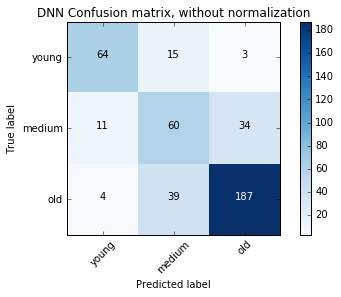

In [10]:
# For the last i=9th cross validation, plot confusion matrices
RF_confusion_matrix = confusion_matrix(test_age_target,RF_predictions)
plt.figure()
plot_confusion_matrix(RF_confusion_matrix,
                      classes=['young','medium','old'],
                      title='RF Confusion matrix, without normalization')

XGB_confusion_matrix = confusion_matrix(test_age_target,XGB_predictions)
plt.figure()
plot_confusion_matrix(XGB_confusion_matrix,
                      classes=['young','medium','old'],
                      title='XGB Confusion matrix, without normalization')

DNN_confusion_matrix = confusion_matrix(test_age_target,DNN_predictions)
plt.figure()
plot_confusion_matrix(DNN_confusion_matrix,
                      classes=['young','medium','old'],
                      title='DNN Confusion matrix, without normalization')
    
all_accuracies.resize(10,3)
print('average accuracy', np.mean(all_accuracies,axis=0))


From the confusion matrix, it looks like most of the false positive and false negatives are between the medium and old, and this is seen in all 3 ML methods.

Data Limited?
This time use only 80% of the data to see if overall accuracy degrades.
This will tell us if we are data limited in terms of increasing accuracy

In [11]:
print(len(age),len(data))
age = age[:int(0.8 * len(age))]
data = data[:int(0.8 * len(data))]
print(len(age),len(data))
test_size = int(len(data) / cross_valid_count)


4177 4177
3341 3341


In [12]:
# do cross validation by using different 10% of data as test set
all_accuracies = np.array([])
for i in range(10):
    train_set = np.concatenate((data[:i*test_size], data[(i+1)*test_size:]),
                               axis=0)
    train_target = np.concatenate((age[:i*test_size], age[(i+1)*test_size:]),
                                  axis=0)
    test_set = data[i * test_size:(i+1) * test_size]
    test_target = age[i * test_size:(i+1) * test_size]

    # convert data to young:0, medium:1, old:2 with 1.5 offset
    train_age_target = convert_to_age_group(train_target)
    test_age_target = convert_to_age_group(test_target)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=1000)
    rf.fit(train_set, train_age_target)
    # do prediction
    RF_predictions = rf.predict(test_set)
    RF_accuracy = accuracy_score(test_age_target, RF_predictions)

    # XGB
    model = xgboost.XGBClassifier(learning_rate=0.1,
                                  n_estimators=1000)
    model.fit(train_set, train_age_target)
    XGB_predictions = model.predict(test_set)
    #XGB_predictions = [round(value) for value in y_pred]
    # evaluate predictions
    XGB_accuracy = accuracy_score(test_age_target, XGB_predictions)

    # DNN
    # Specify that all features have real-value data
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=10)]
    # Build 3 layer DNN with 10, 20, 10 units respectively.
    
    classifier = tf.contrib.learn.DNNClassifier(
        feature_columns=feature_columns,
        hidden_units=[10,20],
        n_classes=3,
        optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.1)
        )
    classifier.fit(x=train_set,
                   y=train_age_target,
                   steps=1000)

    DNN_predictions = classifier.predict(test_set)
    DNN_accuracy = accuracy_score(test_age_target, DNN_predictions)
    
    current_accuracies = np.array([RF_accuracy,XGB_accuracy,DNN_accuracy])
    print('CURRENT ACCURACIES (RF,XGB,DDN)', current_accuracies)
    all_accuracies = np.concatenate([all_accuracies,current_accuracies])


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.04424, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.69161677  0.68562874  0.67065868]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.17043, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.69760479  0.68562874  0.67365269]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.17174, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.67365269  0.67365269  0.69760479]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.12083, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.75748503  0.73952096  0.7245509 ]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.14885, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.69161677  0.70359281  0.70658683]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.12193, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.69161677  0.70958084  0.74251497]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.05504, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.70958084  0.68263473  0.73652695]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.4313, step = 1
INFO:tensorflow:Saving checkpoint

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.68862275  0.70359281  0.69161677]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.07006, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.7005988   0.68562874  0.74251497]


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'save_summary_steps': 100, 'task': 0, '_job_name': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'tf_random_seed': None, '_is_chief': True, 'num_ps_replicas': 0, 'save_checkpoints_secs': 600, 'master': '', 'keep_checkpoint_every_n_hours': 10000, 'cluster_spec': None, 'evaluation_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(10)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.09563, step = 1
INFO:tensorflow:Saving checkpoin

CURRENT ACCURACIES (RF,XGB,DDN) [ 0.73053892  0.73353293  0.73053892]


In [8]:
all_accuracies.resize(10,3)
print('average accuracy', np.mean(all_accuracies,axis=0))

average accuracy [ 0.70959233  0.70383693  0.71534772]


The accuracy numbers are not changed by much compared with when the models had access to the full dataset, so we are probably not limited by the amount of data for these current settings.

In terms of ease of building the model, RF and XGB both provided results quickly, while DNN took a while to train the model, so the earlier two seems less time-consuming iteratively tune.  Given more time, I would chose either RF or XGB to tune for this particular problem, to see if any accuracy gains can be had before I try tuning the DNN.

From initial exploratory tuning, I did not find a big improvements to accuracy adjusting the learning rate of RF and DNN, or the number of trees of RF and XGB.

Given more time, further tuning of the models are possible, such as select a smaller number of features for splitting trees, changing the optimizer routine, changing the number of hidden layers/units for DNN, etc.

In [52]:
xlabels = np.array(convert_to_onehot(df).columns)
xlabels

array(['sex_F', 'sex_I', 'sex_M', 'length', 'diameter', 'height',
       'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight',
       'rings'], dtype=object)

Feature ranking:
1. feature 9 (0.226944)
2. feature 6 (0.138960)
3. feature 7 (0.129750)
4. feature 8 (0.127428)
5. feature 4 (0.118281)
6. feature 5 (0.112352)
7. feature 3 (0.095761)
8. feature 1 (0.024897)
9. feature 2 (0.013074)
10. feature 0 (0.012553)


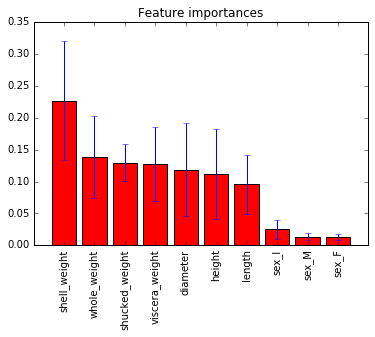

In [55]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_set.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_set.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_set.shape[1]), xlabels[indices], rotation='vertical')
plt.xlim([-1, train_set.shape[1]])
plt.show()

This shows that for random forest, the most important feature is shell_weight column, the other weights and dimension columns are about 1/2 as important, and the sex is not really important.